In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Jun 23 00:05:21 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# ***DESCRIPCION DE LA INFORMACIÓN***




In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import os
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.layers import Flatten,Dense,Dropout,BatchNormalization
from tensorflow.keras.models import Model,Sequential

from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:

# batch_size = 32
# img_height = 224
# img_width = 224

batch_size = 32
img_height = 150
img_width = 150
count_epochs=25

In [4]:
data_dir='/content/drive/MyDrive/analisis matematico/data'


In [5]:
# prompt: data_dir='/content/drive/MyDridver/analisis matematico/data' como saber si esta ruta esta bien

def validar(a):
  if os.path.exists(a):
    print("The directory exists.")
  else:
    print("The directory does not exist.")



validar(data_dir)

The directory exists.


<ipython-input-6-43014f0d8939>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(file_counts.keys()), y=list(file_counts.values()), palette='Set2')


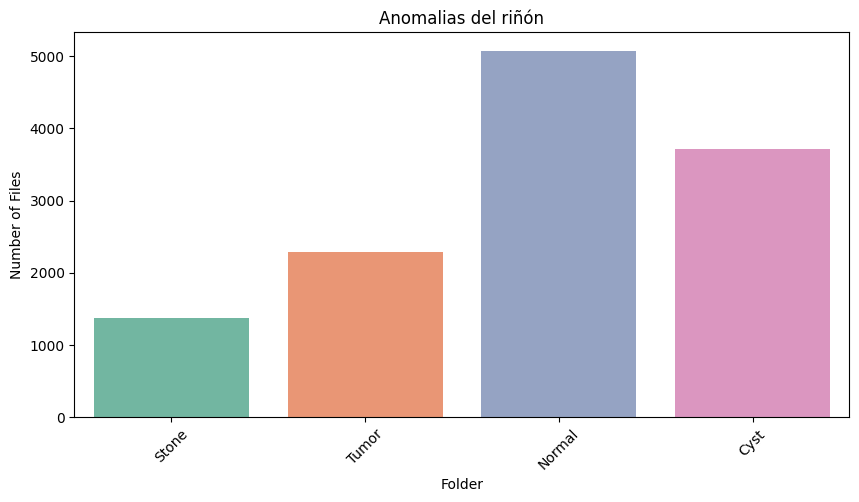

{'Stone': 1377, 'Tumor': 2293, 'Normal': 5077, 'Cyst': 3709}


In [6]:
# prompt: /content/drive/MyDrive/analisis matematico/data  quiero cada uno  de las carpetas y la cantidad de archivo que estan dentro de data, y un grafico de barras hazo con seaborn, cada barra puede tener diferente color
# solo que diga el nombre de la carpeta no toda la ruta

import seaborn as sns
import os
import matplotlib.pyplot as plt
from collections import Counter

# Get the list of folders in the data directory
folders = os.listdir(data_dir)

# Count the number of files in each folder
file_counts = {}
for folder in folders:
  folder_path = os.path.join(data_dir, folder)
  file_counts[folder] = len(os.listdir(folder_path))

# Create a bar chart of the number of files in each folder
plt.figure(figsize=(10, 5))
sns.barplot(x=list(file_counts.keys()), y=list(file_counts.values()), palette='Set2')
plt.xlabel('Folder')
plt.ylabel('Number of Files')
plt.title('Anomalias del riñón')
plt.xticks(rotation=45)
plt.show()
print(file_counts)


In [7]:

dat1=tf.keras.utils.image_dataset_from_directory(data_dir,image_size=(img_height,img_width),
                                                validation_split=0.1,
                                                 subset='training',seed=123)
test=tf.keras.utils.image_dataset_from_directory(data_dir,image_size=(img_height,img_width),
                                                  validation_split=0.1,
                                                  subset='validation',seed=123)

Found 12456 files belonging to 4 classes.
Using 11211 files for training.
Found 12456 files belonging to 4 classes.
Using 1245 files for validation.


In [8]:
# from sklearn.model_selection import train_test_split

# train, val = train_test_split(dat1, test_size=0.2, random_state=42)

In [9]:
train_size = 0.7777  # Proporción del val_test_ds que será usado para validación (2/3)
val_size = 1 - train_size  # Proporción del val_test_ds que será usado para prueba (1/3)
train = dat1.take(int(len(dat1) * train_size))
val = dat1.skip(int(len(dat1) * train_size))

In [10]:
def count_clases(datos):
  all_labels = []
  # Iterar sobre todos los lotes del conjunto de datos val
  for _, labels in datos:
      # Convertir el tensor de etiquetas a un array de NumPy
      labels_np = labels.numpy()

      # Agregar las etiquetas del lote actual a la lista
      all_labels.extend(labels_np.tolist())
  return len(all_labels)

In [11]:
# print(f'Tamaño del conjunto de datos train 70%: {count_clases(train)}')
# print(f'Tamaño del conjunto de datos val 20%: {count_clases(val)}')
# print(f'Tamaño del conjunto de datos test 10%: {count_clases(test)}')

In [12]:
label_to_class_name = dict(zip(range(len(dat1.class_names)), dat1.class_names))
label_to_class_name

{0: 'Cyst', 1: 'Normal', 2: 'Stone', 3: 'Tumor'}

In [13]:
# for image_batch, labels_batch in train:
#   print(image_batch.shape)
#   print(labels_batch.shape)
#   break


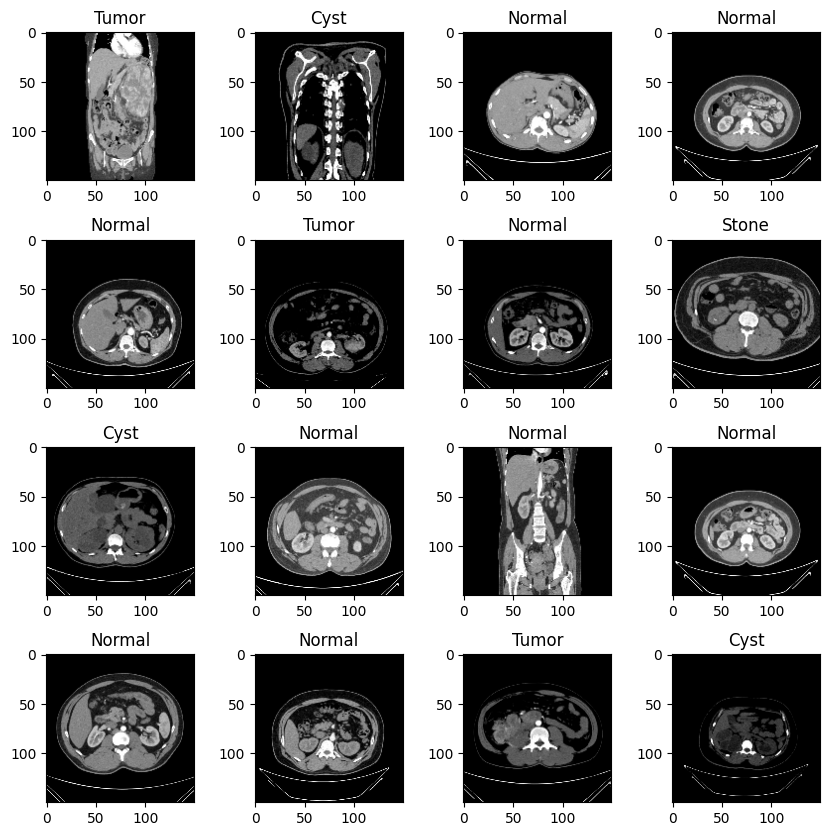

In [14]:
data_iterator = train.as_numpy_iterator()
batch = data_iterator.next()
fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(10, 10))
for i in range(4):
    for j in range(4):
        index = i * 4 + j
        ax[i, j].imshow(batch[0][index].astype(int))
        ax[i, j].set_title(label_to_class_name[batch[1][index]])
plt.subplots_adjust(wspace=0.4, hspace=0.4)
plt.show()

In [15]:
train=train.map(lambda x,y:(x/255,y))
val=val.map(lambda x,y:(x/255,y))
test=test.map(lambda x,y:(x/255,y))

In [16]:
AUTOTUNE = tf.data.AUTOTUNE

train = train.cache().prefetch(buffer_size=AUTOTUNE)
val = val.cache().prefetch(buffer_size=AUTOTUNE)
test = test.cache().prefetch(buffer_size=AUTOTUNE)

# ***VGG 16***

In [17]:
VGG_model = Sequential()

pretrained_model= tf.keras.applications.VGG16(include_top=False, input_shape=(150,150,3), pooling='max',classes=4, weights='imagenet')

VGG_model.add(pretrained_model)
VGG_model.add(Flatten())
VGG_model.add(Dense(512, activation='relu'))
VGG_model.add(BatchNormalization())  # Batch Normalization layer
VGG_model.add(Dropout(0.5))

VGG_model.add(Dense(4, activation='softmax'))
pretrained_model.trainable=False

58889256/58889256 [==============================] - 2s 0us/step


In [18]:
prompt: VGG_model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [19]:
VGG_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 batch_normalization (Batch  (None, 512)               2048      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 2052      
                                                        


history = VGG_model.fit(
  train,
  validation_data=val,
  epochs=count_epochs
)

In [20]:
history = VGG_model.fit(
  train,
  validation_data=val,
  epochs=count_epochs
)

Epoch 1/25
272/272 [==============================] - 1943s 7s/step - loss: 0.5877 - accuracy: 0.7823 - val_loss: 0.7553 - val_accuracy: 0.7292
Epoch 2/25
272/272 [==============================] - 23s 86ms/step - loss: 0.2647 - accuracy: 0.9067 - val_loss: 0.3329 - val_accuracy: 0.8656
Epoch 3/25
272/272 [==============================] - 24s 89ms/step - loss: 0.2038 - accuracy: 0.9273 - val_loss: 0.3001 - val_accuracy: 0.8819
Epoch 4/25
272/272 [==============================] - 24s 90ms/step - loss: 0.1636 - accuracy: 0.9418 - val_loss: 0.1609 - val_accuracy: 0.9386
Epoch 5/25
272/272 [==============================] - 24s 89ms/step - loss: 0.1436 - accuracy: 0.9491 - val_loss: 0.1812 - val_accuracy: 0.9322
Epoch 6/25
272/272 [==============================] - 24s 88ms/step - loss: 0.1285 - accuracy: 0.9538 - val_loss: 0.0971 - val_accuracy: 0.9665
Epoch 7/25
272/272 [==============================] - 24s 88ms/step - loss: 0.1163 - accuracy: 0.9590 - val_loss: 0.1105 - val_accuracy:

In [60]:
VGG_model.save('vgg.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


39/39 [==============================] - 221s 5s/step


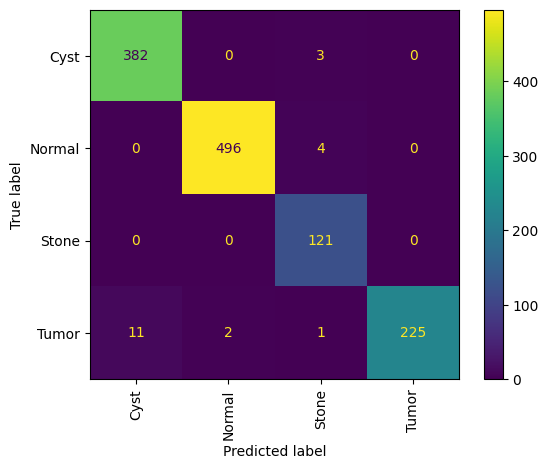

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf

import pickle
from sklearn.metrics import confusion_matrix
import tensorflow as tf
predictions = VGG_model.predict(test)

true_labels = np.concatenate([y for x, y in test], axis=0)

cm = confusion_matrix(true_labels, np.argmax(predictions, axis=1))

with open('confusion_matrix.pkl', 'wb') as f:
    pickle.dump(cm, f)

import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

with open('confusion_matrix.pkl', 'rb') as f:
    cm = pickle.load(f)

class_names = ['Cyst', 'Normal', 'Stone', 'Tumor']

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='viridis', xticks_rotation='vertical', values_format='d')

plt.show()

In [22]:
history_df = pd.DataFrame(history.history)
history_df.to_csv('VGG_training.csv', index=False)

In [23]:
VGG_model.save('VGG_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


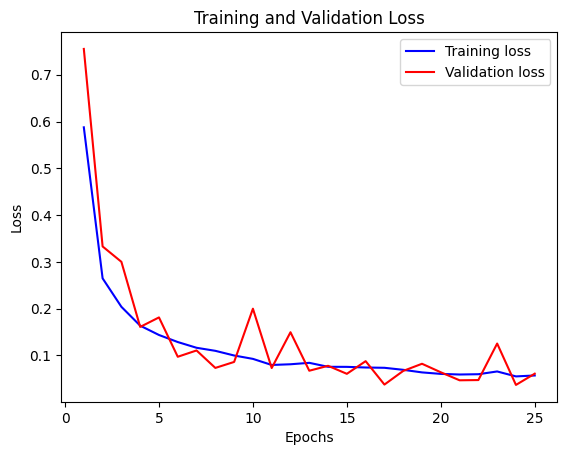

In [24]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

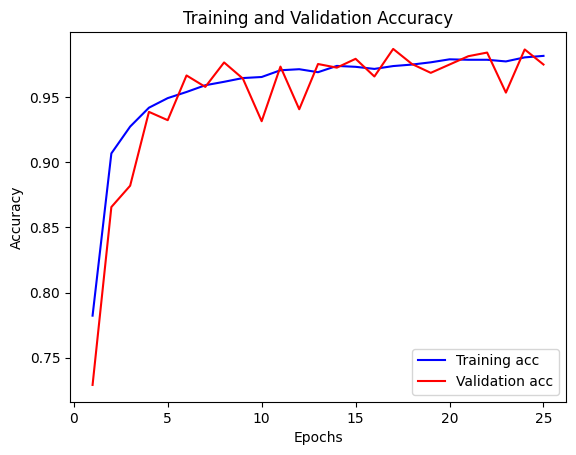

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [26]:
# Evaluar el modelo en el conjunto de validación
loss, accuracy = VGG_model.evaluate(test)

print('Accuracy:', accuracy)

39/39 [==============================] - 3s 66ms/step - loss: 0.0535 - accuracy: 0.9831
Accuracy: 0.983132541179657


In [27]:
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score, recall_score

# Cargar la matriz de confusión desde el archivo
with open('confusion_matrix.pkl', 'rb') as f:
    cm = pickle.load(f)

# Obtener los nombres de las clases
class_names = ['Cyst', 'Normal', 'Stone', 'Tumor']

# Calcular el F1-score y el recall
f1_scores = []
recall_scores = []

for i in range(len(class_names)):
    tn = sum(cm[j][j] for j in range(len(class_names)) if j != i)
    fp = sum(cm[i][j] for j in range(len(class_names)) if j != i)
    fn = sum(cm[j][i] for j in range(len(class_names)) if j != i)
    tp = cm[i][i]

    f1 = 2 * tp / (2 * tp + fp + fn)
    recall = tp / (tp + fn)

    f1_scores.append(f1)
    recall_scores.append(recall)

    print(f'Clase {class_names[i]}:')
    print(f'F1-score: {f1:.2f}')
    print(f'Recall: {recall:.2f}')


Clase Cyst:
F1-score: 0.98
Recall: 0.97
Clase Normal:
F1-score: 0.99
Recall: 1.00
Clase Stone:
F1-score: 0.97
Recall: 0.94
Clase Tumor:
F1-score: 0.97
Recall: 1.00


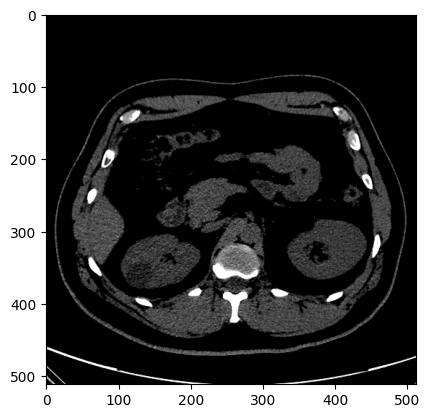

1/1 [==============================] - 1s 1s/step


'Cyst'

In [28]:
a='/content/drive/MyDrive/analisis matematico/data/Cyst/Cyst- (10).jpg'

img = cv2.imread(a)
plt.imshow(img)
plt.show()
resize = tf.image.resize(img, (150,150))
yhat = VGG_model.predict(np.expand_dims(resize/255, 0))
max_index = np.argmax(yhat)
label_to_class_name[max_index]

In [29]:
a='/content/drive/MyDrive/analisis matematico/data/Cyst/Cyst- (10).jpg'

img = cv2.imread(a)
resize = tf.image.resize(img, (150,150))
yhat = VGG_model.predict(np.expand_dims(resize/255, 0))
yhat

1/1 [==============================] - 0s 26ms/step


array([[9.9982446e-01, 4.9276327e-10, 1.7549154e-04, 3.8026883e-08]],
      dtype=float32)

In [30]:
# Lista para almacenar todas las etiquetas
all_labels = []

# Iterar sobre todos los lotes del conjunto de datos val
for _, labels in test:
    # Convertir el tensor de etiquetas a un array de NumPy
    labels_np = labels.numpy()

    # Agregar las etiquetas del lote actual a la lista
    all_labels.extend(labels_np.tolist())
# prompt: predictions quiero que esto sea un dataframe y que este redondeado a 4 decimales

import pandas as pd

# Create a DataFrame from the predictions
predictions_df = pd.DataFrame(predictions)

# Round all values to 4 decimal places
predictions_df = predictions_df.round(4)

# Display the DataFrame
predictions_df

df=predictions_df.copy()


df['result'] = df.max(axis=1)

# Crear la columna "etiqueta" con el índice de la columna que tiene el valor máximo
df['prediction'] = df[[0, 1, 2, 3]].idxmax(axis=1)

df["reliable"]=all_labels
df


,0,1,2,3,result,prediction,reliable
0,0.0000,1.0000,0.0000,0.0000,1.0000,1,1
1,1.0000,0.0000,0.0000,0.0000,1.0000,0,0
2,0.0021,0.9782,0.0197,0.0000,0.9782,1,1
3,1.0000,0.0000,0.0000,0.0000,1.0000,0,0
4,0.0001,0.0078,0.0002,0.9919,0.9919,3,3
...,...,...,...,...,...,...,...
1240,0.0000,1.0000,0.0000,0.0000,1.0000,1,1
1241,0.0145,0.0000,0.0000,0.9855,0.9855,3,3
1242,0.0000,1.0000,0.0000,0.0000,1.0000,1,1
1243,0.9582,0.0000,0.0418,0.0000,0.9582,0,0


In [31]:
df['result_final'] = df['prediction'] == df['reliable']
df

,0,1,2,3,result,prediction,reliable,result_final
0,0.0000,1.0000,0.0000,0.0000,1.0000,1,1,True
1,1.0000,0.0000,0.0000,0.0000,1.0000,0,0,True
2,0.0021,0.9782,0.0197,0.0000,0.9782,1,1,True
3,1.0000,0.0000,0.0000,0.0000,1.0000,0,0,True
4,0.0001,0.0078,0.0002,0.9919,0.9919,3,3,True
...,...,...,...,...,...,...,...,...
1240,0.0000,1.0000,0.0000,0.0000,1.0000,1,1,True
1241,0.0145,0.0000,0.0000,0.9855,0.9855,3,3,True
1242,0.0000,1.0000,0.0000,0.0000,1.0000,1,1,True
1243,0.9582,0.0000,0.0418,0.0000,0.9582,0,0,True


In [32]:
df_group = df.groupby('result_final').size()
print(df_group, "before")
print("=======================")
df = df[df['result_final'] == True]
df_group = df.groupby('result_final').size()
print(df_group, "after")

result_final
False      21
True     1224
dtype: int64 before
result_final
True    1224
dtype: int64 after


In [33]:
result1=df['result'].to_numpy()
result1

array([1.    , 1.    , 0.9782, ..., 1.    , 0.9582, 0.9999], dtype=float32)

# ***DenseNet121***

In [34]:
pretrained_model = tf.keras.applications.DenseNet121(include_top=False, weights='imagenet', input_shape=(150, 150, 3))

Dense_net = Sequential()
Dense_net.add(pretrained_model)
Dense_net.add(GlobalAveragePooling2D())
Dense_net.add(Dense(512, activation='relu'))
Dense_net.add(BatchNormalization())
Dense_net.add(Dropout(0.5))
Dense_net.add(Dense(4, activation='softmax'))

pretrained_model.trainable = False

Dense_net.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Dense_net.summary()

epochs = count_epochs
history = Dense_net.fit(
    train,
    validation_data=val,
    epochs=epochs
)

29084464/29084464 [==============================] - 1s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 4, 4, 1024)        7037504   
                                                                 
 global_average_pooling2d (  (None, 1024)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense_2 (Dense)             (None, 512)               524800    
                                                                 
 batch_normalization_1 (Bat  (None, 512)               2048      
 chNormalization)                                                
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                       

In [61]:
Dense_net.save('dense.h5')

39/39 [==============================] - 6s 122ms/step


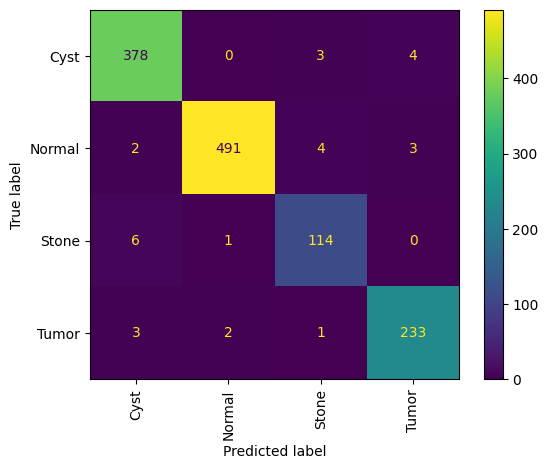

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf

import pickle
from sklearn.metrics import confusion_matrix
import tensorflow as tf
predictions = Dense_net.predict(test)

true_labels = np.concatenate([y for x, y in test], axis=0)

cm = confusion_matrix(true_labels, np.argmax(predictions, axis=1))

with open('confusion_matrix.pkl', 'wb') as f:
    pickle.dump(cm, f)

import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

with open('confusion_matrix.pkl', 'rb') as f:
    cm = pickle.load(f)

class_names = ['Cyst', 'Normal', 'Stone', 'Tumor']

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='viridis', xticks_rotation='vertical', values_format='d')

plt.show()

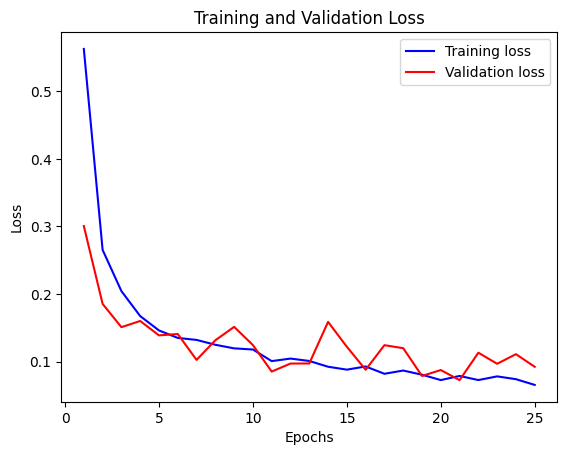

In [36]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

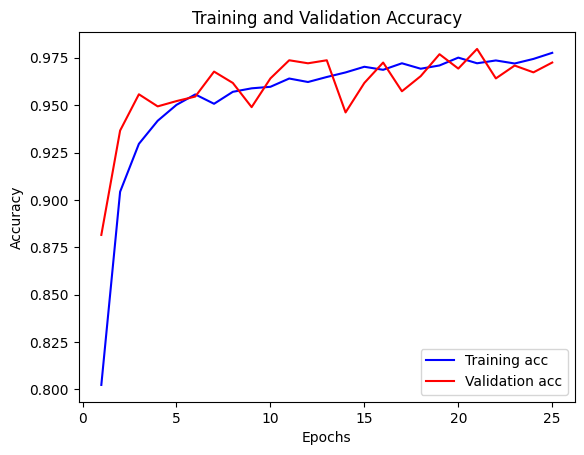

In [37]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [38]:
loss, accuracy = Dense_net.evaluate(test)

print('Accuracy:', accuracy)

39/39 [==============================] - 2s 52ms/step - loss: 0.0850 - accuracy: 0.9767
Accuracy: 0.9767068028450012


In [39]:
# Cargar la matriz de confusión desde el archivo
with open('confusion_matrix.pkl', 'rb') as f:
    cm = pickle.load(f)

# Obtener los nombres de las clases
class_names = ['Cyst', 'Normal', 'Stone', 'Tumor']

# Calcular el F1-score y el recall
f1_scores = []
recall_scores = []

for i in range(len(class_names)):
    tn = sum(cm[j][j] for j in range(len(class_names)) if j != i)
    fp = sum(cm[i][j] for j in range(len(class_names)) if j != i)
    fn = sum(cm[j][i] for j in range(len(class_names)) if j != i)
    tp = cm[i][i]

    f1 = 2 * tp / (2 * tp + fp + fn)
    recall = tp / (tp + fn)

    f1_scores.append(f1)
    recall_scores.append(recall)

    print(f'Clase {class_names[i]}:')
    print(f'F1-score: {f1:.2f}')
    print(f'Recall: {recall:.2f}')


Clase Cyst:
F1-score: 0.98
Recall: 0.97
Clase Normal:
F1-score: 0.99
Recall: 0.99
Clase Stone:
F1-score: 0.94
Recall: 0.93
Clase Tumor:
F1-score: 0.97
Recall: 0.97


In [40]:
# Lista para almacenar todas las etiquetas
all_labels = []

# Iterar sobre todos los lotes del conjunto de datos val
for _, labels in test:
    # Convertir el tensor de etiquetas a un array de NumPy
    labels_np = labels.numpy()

    # Agregar las etiquetas del lote actual a la lista
    all_labels.extend(labels_np.tolist())
# prompt: predictions quiero que esto sea un dataframe y que este redondeado a 4 decimales

import pandas as pd

# Create a DataFrame from the predictions
predictions_df = pd.DataFrame(predictions)

# Round all values to 4 decimal places
predictions_df = predictions_df.round(4)

# Display the DataFrame
predictions_df

df=predictions_df.copy()


df['result'] = df.max(axis=1)

# Crear la columna "etiqueta" con el índice de la columna que tiene el valor máximo
df['prediction'] = df[[0, 1, 2, 3]].idxmax(axis=1)

df["reliable"]=all_labels
df

,0,1,2,3,result,prediction,reliable
0,0.0000,1.0000,0.0000,0.0000,1.0000,1,1
1,1.0000,0.0000,0.0000,0.0000,1.0000,0,0
2,0.0000,1.0000,0.0000,0.0000,1.0000,1,1
3,1.0000,0.0000,0.0000,0.0000,1.0000,0,0
4,0.0000,0.0221,0.0000,0.9779,0.9779,3,3
...,...,...,...,...,...,...,...
1240,0.0000,0.9999,0.0001,0.0000,0.9999,1,1
1241,0.4826,0.0003,0.0000,0.5171,0.5171,3,3
1242,0.0000,1.0000,0.0000,0.0000,1.0000,1,1
1243,0.9999,0.0000,0.0000,0.0001,0.9999,0,0


In [41]:

df['result_final'] = df['prediction'] == df['reliable']
df


,0,1,2,3,result,prediction,reliable,result_final
0,0.0000,1.0000,0.0000,0.0000,1.0000,1,1,True
1,1.0000,0.0000,0.0000,0.0000,1.0000,0,0,True
2,0.0000,1.0000,0.0000,0.0000,1.0000,1,1,True
3,1.0000,0.0000,0.0000,0.0000,1.0000,0,0,True
4,0.0000,0.0221,0.0000,0.9779,0.9779,3,3,True
...,...,...,...,...,...,...,...,...
1240,0.0000,0.9999,0.0001,0.0000,0.9999,1,1,True
1241,0.4826,0.0003,0.0000,0.5171,0.5171,3,3,True
1242,0.0000,1.0000,0.0000,0.0000,1.0000,1,1,True
1243,0.9999,0.0000,0.0000,0.0001,0.9999,0,0,True


In [42]:
df_group = df.groupby('result_final').size()
print(df_group, "before")
print("=======================")
df = df[df['result_final'] == True]
df_group = df.groupby('result_final').size()
print(df_group, "after")

result_final
False      29
True     1216
dtype: int64 before
result_final
True    1216
dtype: int64 after


In [43]:
result2=df['result'].to_numpy()
result2

array([1.    , 1.    , 1.    , ..., 1.    , 0.9999, 0.999 ], dtype=float32)

# *InceptionV3*

In [44]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout
from tensorflow.keras.applications import InceptionV3

# Import InceptionV3
# Crear el modelo preentrenado InceptionV3 sin la capa superior
pretrained_model = InceptionV3(
    include_top=False,
    weights='imagenet',
    input_shape=(150, 150, 3)
)

# Crear un modelo secuencial
Inception = Sequential()
Inception.add(pretrained_model)
Inception.add(GlobalAveragePooling2D())
Inception.add(Dense(512, activation='relu'))
Inception.add(BatchNormalization())
Inception.add(Dropout(0.5))
Inception.add(Dense(4, activation='softmax'))

# Congelar las capas del modelo preentrenado
pretrained_model.trainable = False

# Compilar el modelo
Inception.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Mostrar el resumen del modelo
Inception.summary()

# Entrenar el modelo
epochs = count_epochs # Asegúrate de definir 'count_epochs' o sustituirlo por el número de épocas deseadas
history = Inception.fit(train, validation_data=val, epochs=epochs)

87910968/87910968 [==============================] - 2s 0us/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 3, 3, 2048)        21802784  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_4 (Dense)             (None, 512)               1049088   
                                                                 
 batch_normalization_96 (Ba  (None, 512)               2048      
 tchNormalization)                                               
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                       

In [62]:
Inception.save('inception.h5')

39/39 [==============================] - 4s 79ms/step


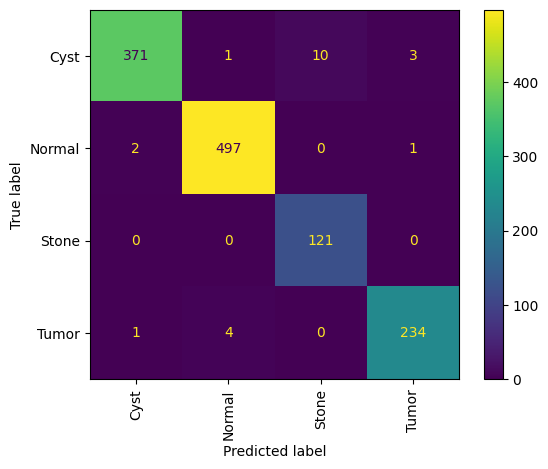

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf

import pickle
from sklearn.metrics import confusion_matrix
import tensorflow as tf
predictions = Inception.predict(test)

true_labels = np.concatenate([y for x, y in test], axis=0)

cm = confusion_matrix(true_labels, np.argmax(predictions, axis=1))

with open('confusion_matrix.pkl', 'wb') as f:
    pickle.dump(cm, f)

import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

with open('confusion_matrix.pkl', 'rb') as f:
    cm = pickle.load(f)

class_names = ['Cyst', 'Normal', 'Stone', 'Tumor']

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='viridis', xticks_rotation='vertical', values_format='d')

plt.show()

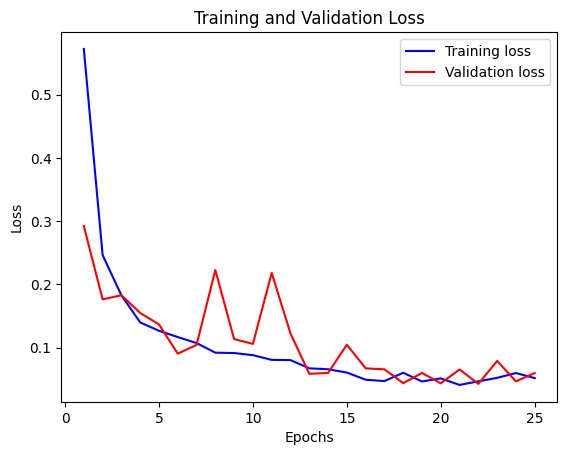

In [46]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

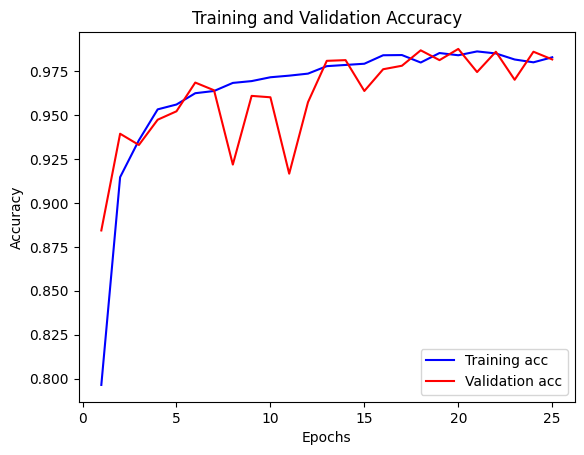

In [47]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [48]:
loss, accuracy = Inception.evaluate(test)

print('Accuracy:', accuracy)

39/39 [==============================] - 1s 31ms/step - loss: 0.0446 - accuracy: 0.9823
Accuracy: 0.9823293089866638


In [49]:
# Cargar la matriz de confusión desde el archivo
with open('confusion_matrix.pkl', 'rb') as f:
    cm = pickle.load(f)

# Obtener los nombres de las clases
class_names = ['Cyst', 'Normal', 'Stone', 'Tumor']

# Calcular el F1-score y el recall
f1_scores = []
recall_scores = []

for i in range(len(class_names)):
    tn = sum(cm[j][j] for j in range(len(class_names)) if j != i)
    fp = sum(cm[i][j] for j in range(len(class_names)) if j != i)
    fn = sum(cm[j][i] for j in range(len(class_names)) if j != i)
    tp = cm[i][i]

    f1 = 2 * tp / (2 * tp + fp + fn)
    recall = tp / (tp + fn)

    f1_scores.append(f1)
    recall_scores.append(recall)

    print(f'Clase {class_names[i]}:')
    print(f'F1-score: {f1:.2f}')
    print(f'Recall: {recall:.2f}')


Clase Cyst:
F1-score: 0.98
Recall: 0.99
Clase Normal:
F1-score: 0.99
Recall: 0.99
Clase Stone:
F1-score: 0.96
Recall: 0.92
Clase Tumor:
F1-score: 0.98
Recall: 0.98


In [50]:
# Lista para almacenar todas las etiquetas
all_labels = []

# Iterar sobre todos los lotes del conjunto de datos val
for _, labels in test:
    # Convertir el tensor de etiquetas a un array de NumPy
    labels_np = labels.numpy()

    # Agregar las etiquetas del lote actual a la lista
    all_labels.extend(labels_np.tolist())
# prompt: predictions quiero que esto sea un dataframe y que este redondeado a 4 decimales

import pandas as pd

# Create a DataFrame from the predictions
predictions_df = pd.DataFrame(predictions)

# Round all values to 4 decimal places
predictions_df = predictions_df.round(4)

# Display the DataFrame
predictions_df

df=predictions_df.copy()


df['result'] = df.max(axis=1)

# Crear la columna "etiqueta" con el índice de la columna que tiene el valor máximo
df['prediction'] = df[[0, 1, 2, 3]].idxmax(axis=1)

df["reliable"]=all_labels
df

,0,1,2,3,result,prediction,reliable
0,0.0000,1.0000,0.0000,0.0000,1.0000,1,1
1,0.9996,0.0003,0.0000,0.0001,0.9996,0,0
2,0.0000,0.9959,0.0004,0.0036,0.9959,1,1
3,0.9786,0.0000,0.0211,0.0003,0.9786,0,0
4,0.0000,0.0310,0.0000,0.9690,0.9690,3,3
...,...,...,...,...,...,...,...
1240,0.0000,1.0000,0.0000,0.0000,1.0000,1,1
1241,0.0000,0.0000,0.0000,1.0000,1.0000,3,3
1242,0.0000,1.0000,0.0000,0.0000,1.0000,1,1
1243,0.9921,0.0000,0.0079,0.0000,0.9921,0,0


In [51]:
df['result_final'] = df['prediction'] == df['reliable']
df


,0,1,2,3,result,prediction,reliable,result_final
0,0.0000,1.0000,0.0000,0.0000,1.0000,1,1,True
1,0.9996,0.0003,0.0000,0.0001,0.9996,0,0,True
2,0.0000,0.9959,0.0004,0.0036,0.9959,1,1,True
3,0.9786,0.0000,0.0211,0.0003,0.9786,0,0,True
4,0.0000,0.0310,0.0000,0.9690,0.9690,3,3,True
...,...,...,...,...,...,...,...,...
1240,0.0000,1.0000,0.0000,0.0000,1.0000,1,1,True
1241,0.0000,0.0000,0.0000,1.0000,1.0000,3,3,True
1242,0.0000,1.0000,0.0000,0.0000,1.0000,1,1,True
1243,0.9921,0.0000,0.0079,0.0000,0.9921,0,0,True


In [52]:
df_group = df.groupby('result_final').size()
print(df_group, "before")
print("=======================")
df = df[df['result_final'] == True]
df_group = df.groupby('result_final').size()
print(df_group, "after")

result_final
False      22
True     1223
dtype: int64 before
result_final
True    1223
dtype: int64 after


In [53]:
result3=df['result'].to_numpy()
result3

array([1.    , 0.9996, 0.9959, ..., 1.    , 0.9921, 1.    ], dtype=float32)

In [54]:
import csv

with open('/content/drive/MyDrive/analisis matematico/result1.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['result1'])
    for row in result3:
        writer.writerow([row])

with open('/content/drive/MyDrive/analisis matematico/result2.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['result2'])
    for row in result3:
        writer.writerow([row])

with open('/content/drive/MyDrive/analisis matematico/result3.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['result3'])
    for row in result3:
        writer.writerow([row])

# ***Kolmogorov-Smirnov***
N=2491       N>50

In [55]:
result1

array([1.    , 1.    , 0.9782, ..., 1.    , 0.9582, 0.9999], dtype=float32)

In [56]:
from scipy.stats import kstest
# Realizamos la prueba de Kolmogorov-Smirnov para cada array
stat1, p1 = kstest(result1, 'norm')
stat2, p2 = kstest(result2, 'norm')
stat3, p3 = kstest(result3, 'norm')

print("Kolmogorov-Smirnov   cantidad de datos=2491")
print('-----------------------------')

# Imprimimos los resultados
print('Resultados para result1:')
print(f'Estadístico de prueba: {stat1}')
print(f'Valor p: {p1}')
alpha = 0.05  # Nivel de significancia
if p1 > alpha:
    print('Los datos de VGG16 parecen seguir una distribución normal')
else:
    print('Los datos de VGG16 no parecen seguir una distribución normal')
print('-----------------------------')

print('Resultados para result2:')
print(f'Estadístico de prueba: {stat2}')
print(f'Valor p: {p2}')
if p2 > alpha:
    print('Los datos de DenseNet121 parecen seguir una distribución normal')
else:
    print('Los datos de DenseNet121 no parecen seguir una distribución normal')
print('-----------------------------')

print('Resultados para result3:')
print(f'Estadístico de prueba: {stat3}')
print(f'Valor p: {p3}')
if p3 > alpha:
    print('Los datos de InceptionV3 parecen seguir una distribución normal')
else:
    print('Los datos de InceptionV3 no parecen seguir una distribución normal')
print('-----------------------------')

Kolmogorov-Smirnov   cantidad de datos=2491
-----------------------------
Resultados para result1:
Estadístico de prueba: 0.7733146895451423
Valor p: 0.0
Los datos de VGG16 no parecen seguir una distribución normal
-----------------------------
Resultados para result2:
Estadístico de prueba: 0.7698844794962231
Valor p: 0.0
Los datos de DenseNet121 no parecen seguir una distribución normal
-----------------------------
Resultados para result3:
Estadístico de prueba: 0.7879307116605264
Valor p: 0.0
Los datos de InceptionV3 no parecen seguir una distribución normal
-----------------------------


# ***Kruskal-Wallis***
La hipótesis nula de la prueba de Kruskal-Wallis asume que las muestras provienen de la misma distribución, mientras que la hipótesis alternativa indica que al menos una de las muestras tiene una distribución diferente.

In [57]:
import pandas as pd
from scipy.stats import kruskal

# # Supongamos que tus datos están en un DataFrame llamado 'df'
# result1 = df['result1']
# result2 = df['result2']
# result3 = df['result3']

# Realizamos la prueba de Kruskal-Wallis
statistic, p_value = kruskal(result1, result2, result3)

# Imprimimos los resultados
print(f'Estadístico de la prueba: {statistic}')
print(f'Valor p: {p_value}')

# Interpretamos el valor p
alpha = 0.05  # Nivel de significancia
if p_value > alpha:
    print('No hay evidencia suficiente para rechazar la hipótesis nula.')
    print('Las distribuciones de las tres columnas son iguales.')
else:
    print('Hay evidencia suficiente para rechazar la hipótesis nula.')
    print('Al menos una de las distribuciones de las tres columnas es diferente.')

Estadístico de la prueba: 8.382423224826045
Valor p: 0.015127944559203218
Hay evidencia suficiente para rechazar la hipótesis nula.
Al menos una de las distribuciones de las tres columnas es diferente.


# ***Pruebas de Mann-Whitney U por pares***

In [58]:
import pandas as pd
from scipy.stats import kruskal, mannwhitneyu

# Realizar la prueba de Kruskal-Wallis
statistic, p_value = kruskal(result1, result2, result3)
print(f"Prueba de Kruskal-Wallis: Estadístico={statistic}, Valor p={p_value}")

# Si al menos una distribución es diferente, realizar pruebas de Mann-Whitney U por pares
if p_value < 0.05:
    print("Al menos una de las distribuciones es diferente.")

    # Comparar result1 vs result2
    statistic_12, p_value_12 = mannwhitneyu(result1, result2)
    print(f"result1 vs result2: Estadístico U={statistic_12}, Valor p={p_value_12}")

    # Comparar result1 vs result3
    statistic_13, p_value_13 = mannwhitneyu(result1, result3)
    print(f"result1 vs result3: Estadístico U={statistic_13}, Valor p={p_value_13}")

    # Comparar result2 vs result3
    statistic_23, p_value_23 = mannwhitneyu(result2, result3)
    print(f"result2 vs result3: Estadístico U={statistic_23}, Valor p={p_value_23}")

    # Determinar la muestra con los valores más altos basándose en el estadístico U más pequeño
    min_u_stat = min(statistic_12, statistic_13, statistic_23)
    if min_u_stat == statistic_12:
        if mannwhitneyu(result1, result2, alternative='greater')[0] > mannwhitneyu(result2, result1, alternative='greater')[0]:
            print("La muestra con los valores más altos es result1.")
        else:
            print("La muestra con los valores más altos es result2.")
    elif min_u_stat == statistic_13:
        if mannwhitneyu(result1, result3, alternative='greater')[0] > mannwhitneyu(result3, result1, alternative='greater')[0]:
            print("La muestra con los valores más altos es result1.")
        else:
            print("La muestra con los valores más altos es result3.")
    else:
        if mannwhitneyu(result2, result3, alternative='greater')[0] > mannwhitneyu(result3, result2, alternative='greater')[0]:
            print("La muestra con los valores más altos es result2.")
        else:
            print("La muestra con los valores más altos es result3.")
else:
    print("No hay evidencia suficiente para rechazar la hipótesis nula.")
    print("Las distribuciones de las tres columnas son iguales.")


Prueba de Kruskal-Wallis: Estadístico=8.382423224826045, Valor p=0.015127944559203218
Al menos una de las distribuciones es diferente.
result1 vs result2: Estadístico U=788510.0, Valor p=0.008432164243211103
result1 vs result3: Estadístico U=755321.5, Valor p=0.6838228337390033
result2 vs result3: Estadístico U=704215.0, Valor p=0.01975015258866904
La muestra con los valores más altos es result3.


In [59]:
print(result1.mean())
print(result2.mean())
print(result3.mean())

0.9837627
0.9838276
0.9886164
